### Pneumonia 

The data are available: https://data.mendeley.com/datasets/rscbjbr9sj/2

#### Import libraries 

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import time
import copy
 

In [13]:
# Set the device to gpu if available 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [14]:
# creation of really helpful functions

# function to print images
def print_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize = (2.5, 2.5))
    plt.axis('off')
    plt.imshow(img)


In [16]:
# creates a transforms sequence for the train set
transf_train = transforms.Compose([
    transforms.Resize(60),
    transforms.RandomCrop(54),
    transforms.ToTensor(), # converts pixels [0-255] to tensors [0-1]
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# creates a second transforms sequence for the train set
transf_train2 = transforms.Compose([
    transforms.Resize(57),
    transforms.RandomRotation(10),
    transforms.RandomCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# creates the transforms sequence for the test and val sets
transf_test = transforms.Compose([
    transforms.Resize(54),
    transforms.CenterCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# loads the images and applies the transformations
train_set = torchvision.datasets.ImageFolder('train', transform = transf_train)
train_set2 = torchvision.datasets.ImageFolder('train', transform = transf_train2)
test_set = torchvision.datasets.ImageFolder('test', transform = transf_test)
val_set = torchvision.datasets.ImageFolder('val', transform = transf_test)

# number of images in each set
train_size = len(train_set)
test_size = len(test_set)
val_size = len(val_set)
print('Train: {} images, Test: {} images, Validation: {} images'.format(train_size, test_size, val_size))

Train: 5216 images, Test: 624 images, Validation: 16 images


Label: NORMAL
Label: PNEUMONIA


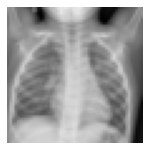

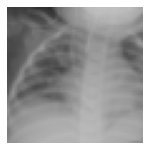

In [18]:
# class labels
class_names = train_set.classes

# a normal x-ray
img, label = train_set[0]
print('Label:', class_names[label])
print_img(img)

img, label = train_set[-1]
print('Label:', class_names[label])
print_img(img)

In [5]:
path = 'chest_xray'

Train set
Normal: 1341 / Pneumonia: 3875


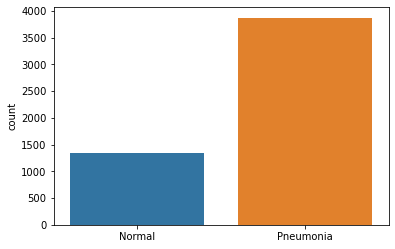

In [19]:
counter = []
x_n = 0
x_p = 0

for i in train_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_p += 1
    else:
        counter.append("Normal")
        x_n += 1

print('Train set')
print('Normal:', x_n, '/ Pneumonia:', x_p)
sns.countplot(x=counter);

Test set
Normal: 234 / Pneumonia: 390


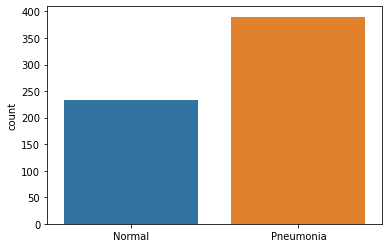

In [20]:
counter = []
x_n = 0
x_p = 0

for i in test_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_p += 1
    else:
        counter.append("Normal")
        x_n += 1

print('Test set')
print('Normal:', x_n, '/ Pneumonia:', x_p)
sns.countplot(x=counter);

Validation set
Normal: 8 / Pneumonia: 8


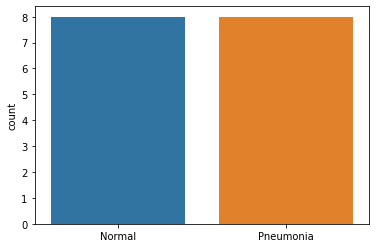

In [21]:
counter = []
x_n = 0
x_p = 0

for i in val_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_p += 1
    else:
        counter.append("Normal")
        x_n += 1

print('Validation set')
print('Normal:', x_n, '/ Pneumonia:', x_p)
sns.countplot(x=counter);

In [ ]:
# Augment train dataset 

In [22]:
train_set2, _ = train_test_split(train_set2, test_size= 3875/train_size, shuffle=False)
train_set = ConcatDataset([train_set, train_set2])

Train set
Normal: 2682 / Pneumonia: 3875


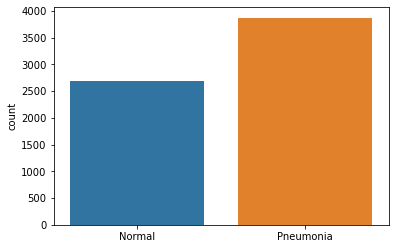

In [23]:
counter = []
x_n = 0
x_p = 0

for i in train_set:
    if i[1] == 1:
        counter.append("Pneumonia")
        x_p += 1
    else:
        counter.append("Normal")
        x_n += 1

print('Train set')
print('Normal:', x_n, '/ Pneumonia:', x_p)
sns.countplot(x=counter);

In [24]:
# Create validation set because  16 pictures are not enough 

train_set, val_set = train_test_split(train_set, test_size=0.2)

train_size = len(train_set)
val_size = len(val_set)


In [25]:
# Create loaders 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32, shuffle = True, num_workers = 8)


### Model 

In [26]:
# import pretrained model
model = torchvision.models.resnet152(pretrained = True)

# number of features in the input of the linear layer
num_ftrs = model.fc.in_features

# sets the number of features of the linear layer
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model summary
summary(model, (3, 50, 50), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 25, 25]           9,408
       BatchNorm2d-2           [16, 64, 25, 25]             128
              ReLU-3           [16, 64, 25, 25]               0
         MaxPool2d-4           [16, 64, 13, 13]               0
            Conv2d-5           [16, 64, 13, 13]           4,096
       BatchNorm2d-6           [16, 64, 13, 13]             128
              ReLU-7           [16, 64, 13, 13]               0
            Conv2d-8           [16, 64, 13, 13]          36,864
       BatchNorm2d-9           [16, 64, 13, 13]             128
             ReLU-10           [16, 64, 13, 13]               0
           Conv2d-11          [16, 256, 13, 13]          16,384
      BatchNorm2d-12          [16, 256, 13, 13]             512
           Conv2d-13          [16, 256, 13, 13]          16,384
      BatchNorm2d-14          [16, 256,

In [ ]:

# function to train model
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        # train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        # validate
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / val_size
        epoch_acc = running_corrects.double() / val_size
        print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('-' * 30)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model)
    return model


# function to predict images and display the accuracy
def visualize_predictions(model, dataset):
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            input, label = dataset[i]
            input = input[np.newaxis,:]
            input = input.to(device)
            output = model(input)
            _, preds = torch.max(output, 1)
            if class_names[label] == class_names[preds]:
                acc += 1
            labels.append(class_names[label])
            predictions.append(class_names[preds])
    print('Test Accuracy: {:.4f}'.format(acc/len(dataset)))
    model.train(mode=was_training)
    return labels, predictions

In [27]:
# train the model
model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/5
Train Loss: 0.1356 Train Acc: 0.9432
Val Loss: 0.0824 Val Acc: 0.9771
------------------------------
Epoch 2/5
Train Loss: 0.0506 Train Acc: 0.9798
Val Loss: 0.0788 Val Acc: 0.9741
------------------------------
Epoch 3/5
Train Loss: 0.0195 Train Acc: 0.9941
Val Loss: 0.0641 Val Acc: 0.9741
------------------------------
Epoch 4/5
Train Loss: 0.0136 Train Acc: 0.9958
Val Loss: 0.1049 Val Acc: 0.9649
------------------------------
Epoch 5/5
Train Loss: 0.0291 Train Acc: 0.9897
Val Loss: 0.0957 Val Acc: 0.9703
------------------------------
Training complete in 3m 25s
Best Val Acc: 0.9771


In [ ]:
# Plot the learning curves 






In [28]:
# predicting the test set
labels, predictions = visualize_predictions(model, test_set)

Test Accuracy: 0.9199


<Figure size 432x288 with 0 Axes>

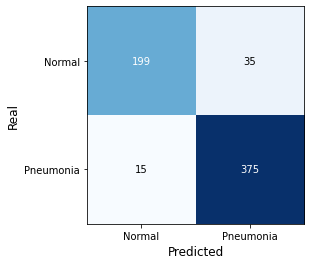

In [29]:
# confusion matrix
matrix = confusion_matrix(labels, predictions)
plt.figure()
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

In [7]:
transformer = {
    'data1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'data2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'data3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [9]:
data1 = ImageFolder(path+'/train', 
                      transform=transformer['data1'])

data2 = ImageFolder(path+'/train', 
                      transform=transformer['data2'])

data3 = ImageFolder(path+'/train', 
                      transform=transformer['data3'])

norm1, _ = train_test_split(data2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(data3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([data1, norm1, norm2])

len(dataset)

7750